In [1]:
import pandas as pd
from fractions import Fraction
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')

### Helpers

In [2]:
PITCH_NAMES = {0: 'F', 1: 'C', 2: 'G', 3: 'D', 4: 'A', 5: 'E', 6: 'B'}

def tpc2name(tpc):
    """Return name of a tonal pitch class where
       0 = C, -1 = F, -2 = Bb, 1 = G etc.
    """
    try:
        tpc = int(tpc) + 1 # to make the lowest name F = 0 instead of -1
    except:
        raise ValueError(f"'{tpc}' is not a TPC.")

    acc = abs(tpc // 7) * 'b' if tpc < 0 else tpc // 7 * '#'
    return PITCH_NAMES[tpc % 7] + acc

# Loading the note lists for ~700 compositions

* id: which piece
* mn: measure number (=bar number)
* onset: distance from the measure's beginning (expressed as fraction of a whole note, so that 1/4 = quarter note)
* duration: duration (expressed as fraction of a whole note, so that 1/4 = quarter note)
* tpc: tonal pitch class, expressed on the line of fifth with (any) C = 0 (see below)
* midi: pitch expressed as piano key with 60 = C4
* keysig: Key signature of the score, 3 = 3 sharps; -3 = 3 flats
* timesig: Time signature of the score (question: why isn't this column conserved as a string, instead of parsing the fraction?)

### TPC (extends in both directions)

|tpc|pitch|accidental|
|---|-----|----------|
|-9|B|$\flat\flat$|
|-8|F|$\flat$|
|-7|C|$\flat$|
|-6|G|$\flat$|
|-5|D|$\flat$|
|-4|A|$\flat$|
|-3|E|$\flat$|
|-2|B|$\flat$|
|-1|F||
|0|C||
|1|G||
|2|D||
|3|A||
|4|E||
|5|B||
|6|F|$\sharp$|
|7|C|$\sharp$|
|8|G|$\sharp$|
|9|D|$\sharp$|
|10|A|$\sharp$|
|11|E|$\sharp$|
|12|B|$\sharp$|
|13|F|$\sharp\sharp$|


In [3]:
dtypes = dict({col: int for col in ['id', 'mn', 'tpc', 'midi']}, timesig=str)
converters = {col: Fraction for col in ['onset', 'duration']}
notes = pd.read_csv('note_list.tsv', sep='\t', dtype=dtypes, converters=converters)
print(notes.shape)
notes.head(5)

(65534, 7)


,id,mn,onset,duration,tpc,midi,timesig
0,0,1,0,1/16,3,45,12/8
1,0,1,1/16,1/16,7,49,12/8
2,0,1,1/8,1/16,4,52,12/8
3,0,1,3/16,1/16,3,57,12/8
4,0,1,1/4,1/16,8,56,12/8


# Counting notes 

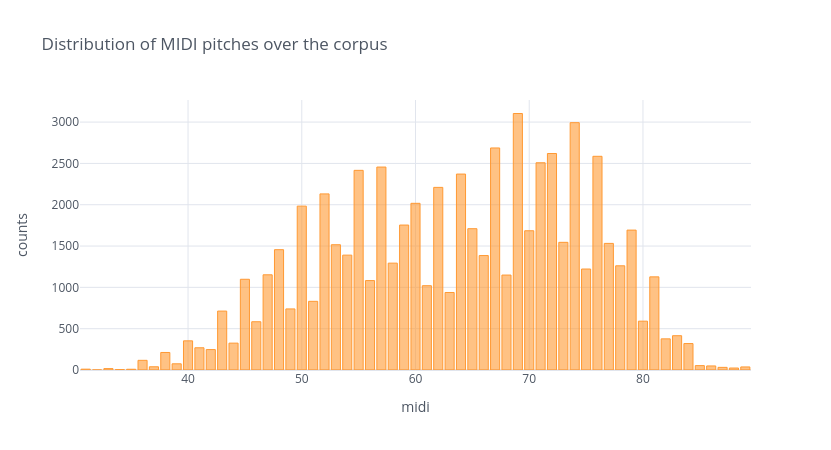

In [4]:
notes.midi.value_counts().iplot('bar', title='Distribution of MIDI pitches over the corpus', xTitle='midi', yTitle='counts')

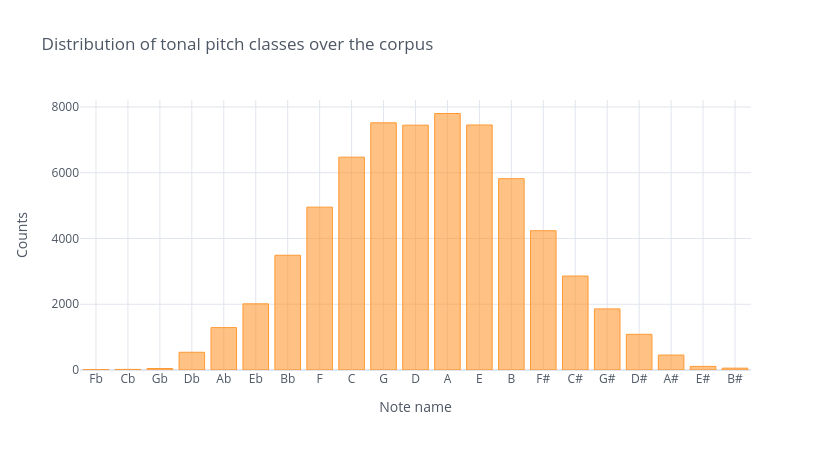

In [5]:
notes.tpc.value_counts()\
        .sort_index()\
        .rename(tpc2name)\
        .iplot('bar', title='Distribution of tonal pitch classes over the corpus', xTitle='Note name', yTitle='Counts')

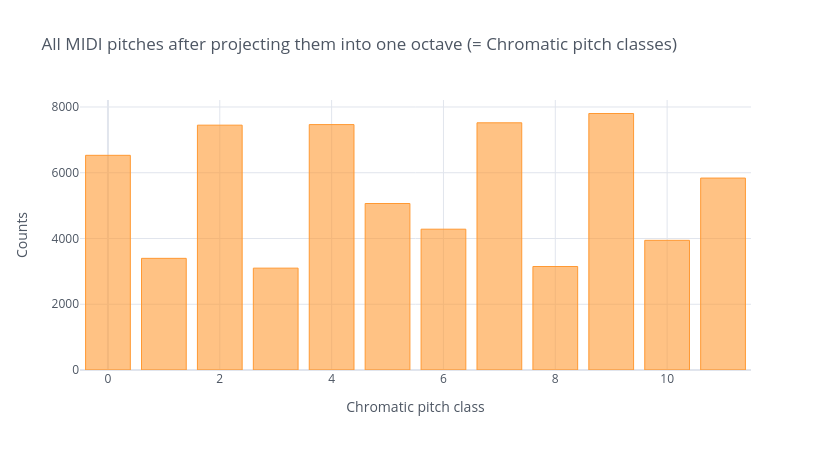

In [6]:
notes['pc'] = notes.midi.map(lambda x: x%12)
notes.pc.value_counts().iplot('bar', title='All MIDI pitches after projecting them into one octave (= Chromatic pitch classes)', xTitle='Chromatic pitch class', yTitle='Counts')

As noted in class, this distribution shows how often every key of the piano is pressed if you play all notes of all pieces in the middle octave. The plot reveals that

* the white keys [0, 2, 4, 5, 7, 9, 11] will be pressed more frequently than the black keys [1, 3, 6, 8, 10],
* Bb/A# is the most frequent black key,
* B/Cb  is the least frequent white key.

### How many notes in one piece?

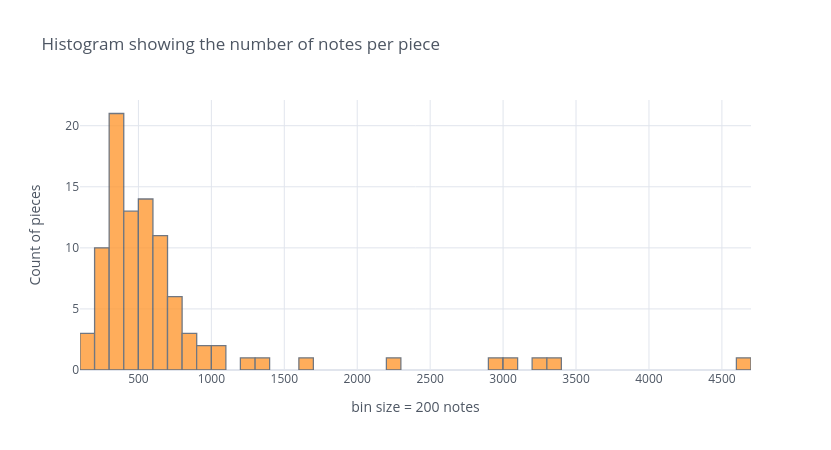

In [7]:
notes.groupby('id').size().iplot('hist', bins=50, title='Histogram showing the number of notes per piece', xTitle='bin size = 200 notes', yTitle='Count of pieces')

### Tone counts per piece

In [8]:
norm = lambda df: df.div(df.sum(axis=1), axis=0)

In [9]:
pc_counts = notes.groupby('id').pc.value_counts().unstack()
pc_counts = norm(pc_counts)
pc_counts.head(10)

pc,0,1,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,
0,0.002307,0.133795,0.116494,0.023068,0.154556,0.010381,0.131488,0.023068,0.103806,0.146482,0.014994,0.139562
1,0.010288,0.128601,0.069959,0.047325,0.155350,0.011317,0.130658,0.017490,0.116255,0.144033,0.029835,0.138889
2,NaN,0.126904,0.076142,0.035533,0.159898,0.012690,0.129442,NaN,0.126904,0.170051,0.005076,0.157360
3,NaN,0.145585,0.095465,0.014320,0.159905,NaN,0.116945,0.045346,0.066826,0.150358,0.023866,0.181384
4,NaN,0.136000,0.114000,0.020000,0.166000,NaN,0.120000,0.042000,0.076000,0.138000,0.024000,0.164000
5,NaN,0.126984,0.099206,0.015873,0.170635,NaN,0.113095,0.039683,0.071429,0.164683,0.017857,0.180556
6,0.017582,0.116484,0.140659,0.010989,0.178022,0.015385,0.109890,0.048352,0.061538,0.142857,0.013187,0.145055
7,NaN,0.162021,0.104530,0.020906,0.163763,0.001742,0.090592,0.013937,0.087108,0.172474,0.005226,0.177700
8,0.131519,0.009070,0.124717,0.006803,0.170068,0.095238,0.031746,0.072562,0.047619,0.156463,0.004535,0.149660


Cufflinks uses the index for the x-axis and every column as one trace. That's why the DataFrame needs to be transposed for this plot:

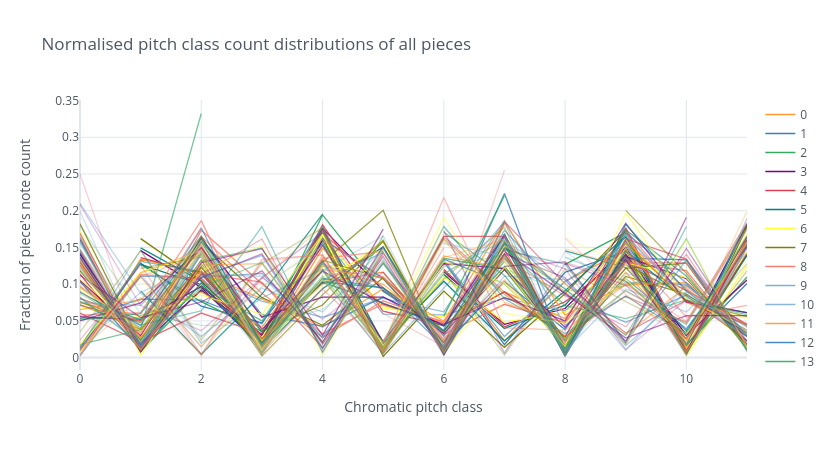

In [10]:
pc_counts.T.iplot(title='Normalised pitch class count distributions of all pieces', xTitle='Chromatic pitch class', yTitle="Fraction of piece's note count")

### Tone durations per piece

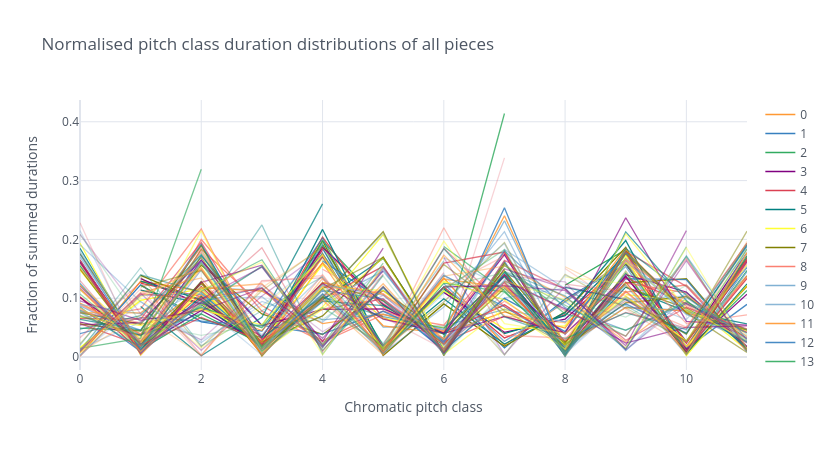

In [11]:
pc_durations = notes.groupby(['id', 'pc']).duration.sum().unstack()
pc_durations = norm(pc_durations).astype(float)
pc_durations.T.iplot(title='Normalised pitch class duration distributions of all pieces', xTitle='Chromatic pitch class', yTitle='Fraction of summed durations')

# Assignment: Tonal Hierarchy

* As you see, different pieces favour different sets of pitches.
* Use your knowledge about tonal hierarchies to infer from the data for every piece its global key, that is
    * its root
    * whether it is in minor or major.
* Use the distributions of pitch durations rather than those of pitch counts.
* Small caveat: You can expect the root and the fifth above it to be the two most frequent pitches, but in many cases, the fifth is more frequent than the root. Why do you think is that and how can we solve the problem?
* Solve the problem with the MIDI information (i.e., pitch classes) and compare it to the ground truth. Note that from the chromatic pitch class that you name as root, you can only guess the correct tonal pitch class.

## Additional task for digging deeper

How does the task change if we use tonal pitch classes for finding the key?

### Hint 1

One way to go at it would consist in transposing the tone distributions to set the root to 0. You can apply this function to rotate a row by n:

In [12]:
import numpy as np
rotate_series = lambda row, n: pd.Series(np.roll(row, n))

### Hint 2
This is what the mean of the ground truth for major and minor looks like:

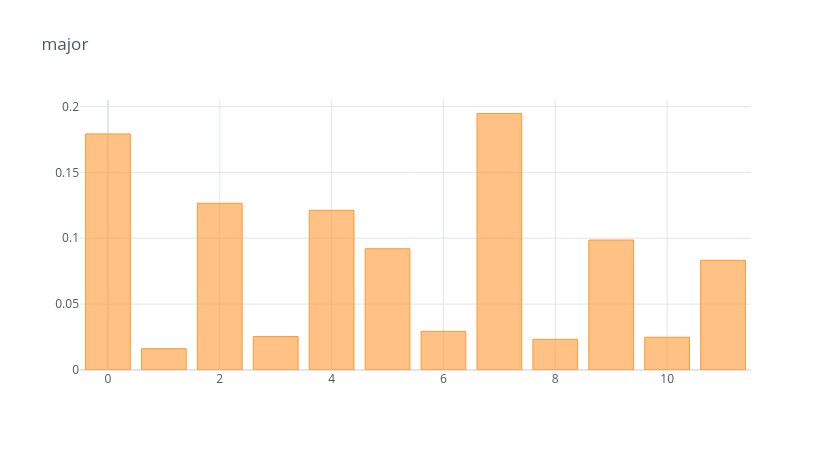

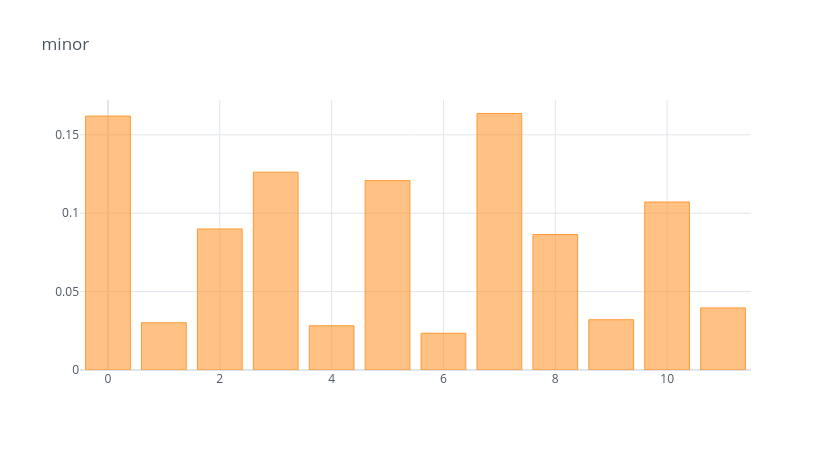

In [13]:
major_mean_pc_duration = {
 0: 0.1792334741300649,
 1: 0.016194246522623856,
 2: 0.12655280537743901,
 3: 0.025386044326330903,
 4: 0.12121976418935039,
 5: 0.09207725352852898,
 6: 0.02930039349131656,
 7: 0.19473155624848157,
 8: 0.02324467767869272,
 9: 0.09867587704734578,
 10: 0.024848467922041463,
 11: 0.08326001666922679}

minor_mean_pc_duration = {
 0: 0.16195224046022005,
 1: 0.03014516030424735,
 2: 0.08993909167778845,
 3: 0.1261668911358516,
 4: 0.02821709371392731,
 5: 0.12078263380972043,
 6: 0.023455154424039615,
 7: 0.16359499887584905,
 8: 0.08642460807252482,
 9: 0.032053164535953325,
 10: 0.10712390344531529,
 11: 0.039598903486405754}
pd.Series(major_mean_pc_duration).iplot('bar', title='major')
pd.Series(minor_mean_pc_duration).iplot('bar', title='minor')

### Loading the ground truth

In [14]:
keys = pd.read_csv('keys.tsv', sep='\t', index_col=0)
keys['mode'] = keys.globalkey.str.isupper().replace({True: 'major', False:'minor'})
keys.head(11)

,globalkey,mode
id,,
0,A,major
1,A,major
2,A,major
3,A,major
4,A,major
5,A,major
6,A,major
7,A,major
8,a,minor


# Solutions
## 1. Theoretically informed approach
### Get tone profiles for every piece

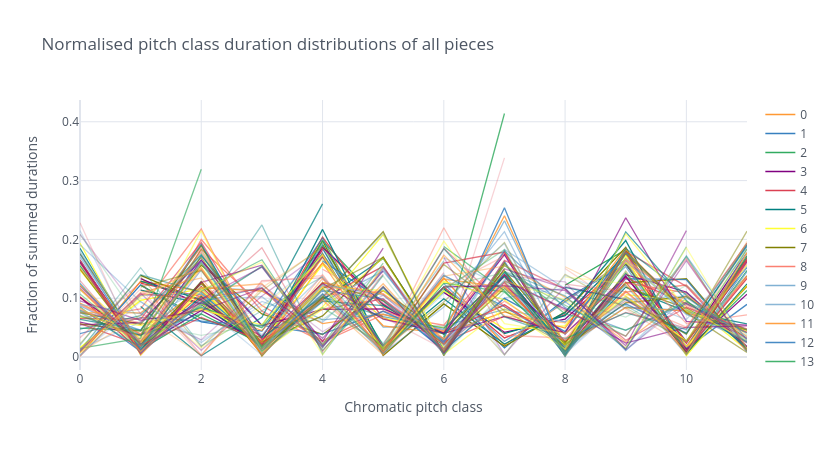

In [15]:
pc_durations.T.iplot(title='Normalised pitch class duration distributions of all pieces', xTitle='Chromatic pitch class', yTitle='Fraction of summed durations')

### Rotate distributions to 0 == max

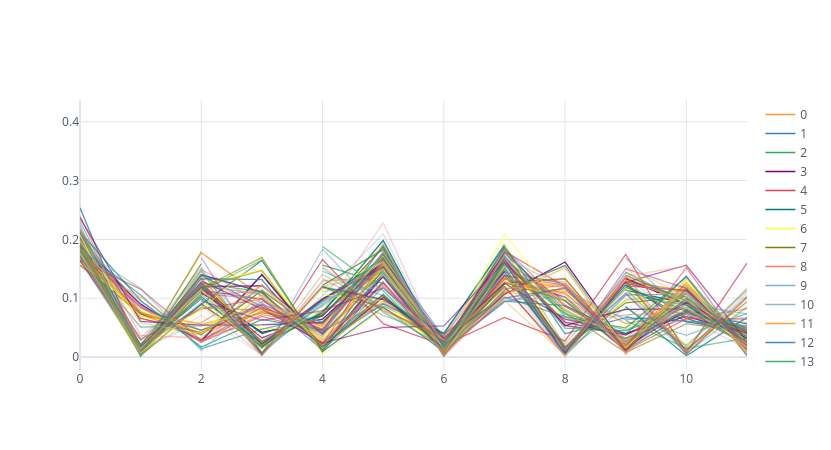

In [16]:
rotate_to_max = lambda row: pd.Series(np.roll(row, -row.idxmax()))

rolled_dur = pc_durations.apply(rotate_to_max, axis=1)
rolled_dur.T.iplot()

### Further rotate those where 5 is the second maximum

In [17]:
second_most = rolled_dur[range(1,12)].idxmax(axis=1)
second_most.value_counts()

5    42
7    37
4     5
2     4
3     2
8     2
9     2
dtype: int64

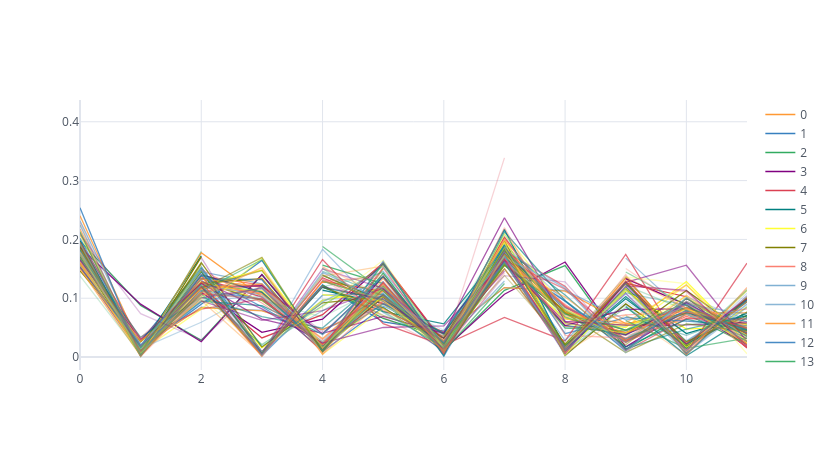

In [18]:
fourth_to_root = lambda row: pd.Series(np.roll(row, -5))

rolled_correct = rolled_dur.copy()
rolled_correct.loc[second_most == 5] = rolled_correct.loc[second_most == 5].apply(fourth_to_root, axis=1)
rolled_correct.T.iplot()

### 4 > 3 = major; 4 < 3 = minor

In [19]:
mode = rolled_correct.apply(lambda r: 'minor' if r[3] > r[4] else 'major', axis=1)
mode.head(10)

id
0    major
1    major
2    major
3    major
4    major
5    major
6    major
7    major
8    minor
9    major
dtype: object

### Ground truth keys

In [20]:
keys['predicted'] = mode

In [21]:
(keys['mode'] == keys.predicted).value_counts()

False    549
True      85
dtype: int64

In [22]:
keys.head(10)

,globalkey,mode,predicted
id,,,
0,A,major,major
1,A,major,major
2,A,major,major
3,A,major,major
4,A,major,major
5,A,major,major
6,A,major,major
7,A,major,major
8,a,minor,minor


In [23]:
most_frequent = pc_durations.idxmax(axis=1)
most_frequent.loc[second_most == 5] = most_frequent.loc[second_most == 5].map(lambda x: (x+5)%12)
most_frequent.head(10)

id
0    9
1    9
2    9
3    4
4    4
5    9
6    9
7    9
8    9
9    9
dtype: int64

In [24]:
import re

NAME_PCS = {
    'C': 0,
    'D': 2,
    'E': 4,
    'F': 5,
    'G': 7,
    'A': 9,
    'B': 11,
}

def split_note_name(nn):
    nn = str(nn)
    m = re.match("^([A-G]|[a-g])(#*|b*)$", nn)
    assert m is not None, nn + " is not a valid note name."
    return m.group(1), m.group(2)

def name2pc(nn):
    nn_step, nn_acc = split_note_name(nn)
    nn_step = nn_step.upper()
    step_pc = NAME_PCS[nn_step]
    return (step_pc + nn_acc.count('#') - nn_acc.count('b')) % 12

In [25]:
keys['root_pc'] = keys.globalkey.map(name2pc)
keys['root_predicted'] = most_frequent

In [26]:
(keys.root_pc == keys.root_predicted).value_counts()

False    556
True      78
dtype: int64

## 2. Krumhansl-Schmuckler Key-Finding Algorithm
### Rotate key profiles

In [52]:
key_profiles = {
    'major': np.array(list(major_mean_pc_duration.values())),
    'minor': np.array(list(minor_mean_pc_duration.values()))
}
rotated_kp = {(mode, rotation): np.roll(kp, rotation) for mode, kp in key_profiles.items() for rotation in range(12)}
rotated_kp

{('major',
  0): array([0.17923347, 0.01619425, 0.12655281, 0.02538604, 0.12121976,
        0.09207725, 0.02930039, 0.19473156, 0.02324468, 0.09867588,
        0.02484847, 0.08326002]),
 ('major',
  1): array([0.08326002, 0.17923347, 0.01619425, 0.12655281, 0.02538604,
        0.12121976, 0.09207725, 0.02930039, 0.19473156, 0.02324468,
        0.09867588, 0.02484847]),
 ('major',
  2): array([0.02484847, 0.08326002, 0.17923347, 0.01619425, 0.12655281,
        0.02538604, 0.12121976, 0.09207725, 0.02930039, 0.19473156,
        0.02324468, 0.09867588]),
 ('major',
  3): array([0.09867588, 0.02484847, 0.08326002, 0.17923347, 0.01619425,
        0.12655281, 0.02538604, 0.12121976, 0.09207725, 0.02930039,
        0.19473156, 0.02324468]),
 ('major',
  4): array([0.02324468, 0.09867588, 0.02484847, 0.08326002, 0.17923347,
        0.01619425, 0.12655281, 0.02538604, 0.12121976, 0.09207725,
        0.02930039, 0.19473156]),
 ('major',
  5): array([0.19473156, 0.02324468, 0.09867588, 0.02484847

In [65]:
from scipy.stats.stats import pearsonr

key_tuples = list(rotated_kp.keys())

def max_correlation(row):
    coeffs = np.array([pearsonr(row, kp)[0] for kp in rotated_kp.values()])
    return key_tuples[coeffs.argmax()]
    

max_correlation(pc_durations.loc[0].to_numpy())

('major', 9)

In [66]:
pc_durations.fillna(0).apply(max_correlation, axis=1)

id
0     (major, 9)
1     (major, 9)
2     (major, 9)
3     (major, 9)
4     (major, 9)
         ...    
89    (minor, 5)
90    (major, 5)
91    (minor, 5)
92    (minor, 5)
93    (major, 0)
Length: 94, dtype: object

In [55]:
t = pc_durations.loc[0].to_numpy()

In [28]:
np.array(pc_durations.loc[0].to_numpy(), ndmin=2).shape

(1, 12)

In [29]:
np.corrcoef(t, pc_durations.loc[0].to_numpy(), rowvar=False)

array([[ 1.        , -0.19787157],
       [-0.19787157,  1.        ]])

In [32]:

pearsonr(t, pc_durations.loc[0].to_list())

(-0.1978715655652572, 0.5375920596391792)

In [ ]:
pc_durations.loc[0]